### A Simplied Interface to Text Classification With Hugging Face Transformers in TensorFlow Using [ktrain](https://github.com/amaiya/ktrain)

*ktrain* requires TensorFlow 2.

Steps to install ktrain:
- install ktrain - this will remove the current version of sklearn
- uninstall old version of sklearn
- install sklearn
- restart
- check ktrain version

In [1]:
import sklearn

sklearn.__version__

'1.0.2'

In [ ]:
!pip install -q ktrain
#!pip uninstall ktrain -y

     |████████████████████████████████| 25.3 MB 66.6 MB/s 
     |████████████████████████████████| 6.8 MB 41.4 MB/s 
     |████████████████████████████████| 981 kB 46.2 MB/s 
     |████████████████████████████████| 263 kB 49.7 MB/s 
     |████████████████████████████████| 2.8 MB 36.9 MB/s 
     |████████████████████████████████| 1.2 MB 45.9 MB/s 
     |████████████████████████████████| 468 kB 41.5 MB/s 
     |████████████████████████████████| 596 kB 43.4 MB/s 
     |████████████████████████████████| 61 kB 536 kB/s 
     |████████████████████████████████| 3.3 MB 37.6 MB/s 
     |████████████████████████████████| 895 kB 47.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.2 which is incompatible.


In [3]:
!pip uninstall scikit-learn -y

In [4]:
!pip install scikit-learn
# reboot

     |████████████████████████████████| 24.8 MB 44.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ktrain 0.28.3 requires scikit-learn==0.23.2, but you have scikit-learn 1.0.2 which is incompatible.


In [2]:
import ktrain
ktrain.__version__

'0.28.3'

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from ktrain import text

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
% cd /content/drive/MyDrive/Colab Notebooks/BuildingDefect_Deakin

/content/drive/MyDrive/Colab Notebooks/BuildingDefect_Deakin


In [6]:
!pip3 install -q tensorflow

In [7]:
import tensorflow as tf
print(tf.__version__)

2.7.0


### Load a Dataset


In [8]:
df = pd.read_csv('wiseworking_train.csv')
df_test = pd.read_csv('wiseworking_test.csv')
print('Len train:', len(df))
print('Len test:', len(df_test))
categories = df['Category'].unique()
categories

Len train: 24459
Len test: 1766


array(['Windows/Facade', 'Door/Hardware', 'Mechanical', 'Plumbing',
       'Appliance', 'Joinery', 'Flooring', 'Electrical',
       'Tile/Stone/Caulking', 'Finishes', 'Leak', 'Paint',
       'Fixtures/Fittings', 'Plaster', 'Shower Screen', 'Balustrade',
       'Waterproofing', 'Water Damage', 'Roof', 'Fire Services',
       'Structural'], dtype=object)

In [9]:
def plot_data(keys, values, title):
    plt.figure(figsize=(8,4))
    plt.bar(keys, values)
    plt.xticks(rotation=90)
    plt.subplots_adjust(bottom=0.3)
    plt.title = title
    plt.show()

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


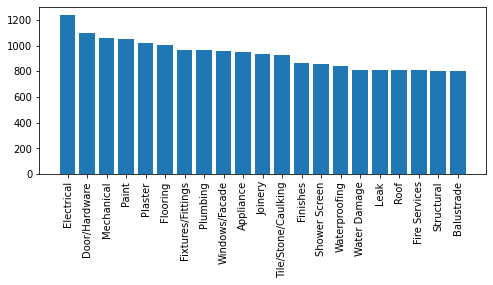

['Intercom not working', 'Loose floorboard that is squeaking quite a bit.', 'Bathroom door and framing need to embody replaced', 'Condensation issues to be addressed - Lauren - possessor', 'small panel on top staircase needs one coat of paint.']
['Electrical' 'Flooring' 'Water Damage' 'Waterproofing' 'Paint']


In [10]:
X = df[['Description']]
y = df[['Category']]

X_test = df_test[['Description']]
y_test = df_test[['Category']]

# No need to split dataset anymore
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state = 1, stratify = df['Category'])

print(type(X_train))
print(type(y_train))

unique_categories_count = y_train.Category.value_counts()
plot_data(unique_categories_count.index, unique_categories_count.values, 'Category')

X_train = X_train.Description.values.tolist()
y_train = y_train.Category.to_numpy()
X_test = X_test.Description.values.tolist()
y_test = y_test.Category.to_numpy()
X_val = X_val.Description.values.tolist()
y_val = y_val.Category.to_numpy()
print(X_train[:5])
print(y_train[:5])

### Preprocess Data and Create a Transformer Model

We will use [DistilBERT](https://arxiv.org/abs/1910.01108).

In [11]:
MODEL_NAME = 'distilbert-base-uncased'
t = text.Transformer(MODEL_NAME, maxlen=500, classes=categories)
trn = t.preprocess_train(X_train, y_train)
val = t.preprocess_test(X_val, y_val)
model = t.get_classifier()

/usr/local/lib/python3.7/dist-packages/ktrain/text/preprocessor.py:420: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn('The class_names argument is replacing the classes argument. Please update your code.')


preprocessing train...
language: en
train sequence lengths:
	mean : 26
	95percentile : 75
	99percentile : 125


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 26
	95percentile : 75
	99percentile : 139


In [ ]:
# load from checkpoint if necessary
#model.load_weights('/content/drive/MyDrive/Colab Notebooks/weights-02.hdf5')

In [12]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=16)

In [13]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = "balanced", classes = categories, y = y_train)
train_class_weights = dict(enumerate(class_weights))

### Train the Model

In [13]:
!pwd

/content/drive/MyDrive/Colab Notebooks/BuildingDefect_Deakin


In [14]:
num_epochs = 5
learner.fit_onecycle(5e-5, num_epochs, class_weight=train_class_weights, checkpoint_folder='/content/drive/MyDrive/Colab Notebooks/BuildingDefect_Deakin')



begin training using onecycle policy with max lr of 5e-05...
Epoch 1/5
1223/1223 [==============================] - 2258s 2s/step - loss: 1.9526 - accuracy: 0.4762 - val_loss: 0.9451 - val_accuracy: 0.7224
Epoch 2/5
1223/1223 [==============================] - 2236s 2s/step - loss: 0.6867 - accuracy: 0.7994 - val_loss: 0.5470 - val_accuracy: 0.8357
Epoch 3/5
1223/1223 [==============================] - 2235s 2s/step - loss: 0.3689 - accuracy: 0.8859 - val_loss: 0.4296 - val_accuracy: 0.8753
Epoch 4/5
1223/1223 [==============================] - 2236s 2s/step - loss: 0.1361 - accuracy: 0.9598 - val_loss: 0.3229 - val_accuracy: 0.9158
Epoch 5/5
1223/1223 [==============================] - 2235s 2s/step - loss: 0.0462 - accuracy: 0.9878 - val_loss: 0.2786 - val_accuracy: 0.9289


### Evaluate and Inspect the Model

In [15]:
learner.validate(class_names=t.get_classes())

                     precision    recall  f1-score   support

          Appliance       0.93      0.89      0.91       238
         Balustrade       1.00      1.00      1.00       200
      Door/Hardware       0.86      0.87      0.86       274
         Electrical       0.93      0.90      0.92       309
           Finishes       0.87      0.96      0.91       216
      Fire Services       1.00      1.00      1.00       201
  Fixtures/Fittings       0.85      0.86      0.86       241
           Flooring       0.95      0.96      0.95       250
            Joinery       0.89      0.82      0.85       235
               Leak       0.93      0.99      0.96       203
         Mechanical       0.92      0.97      0.94       265
              Paint       0.88      0.80      0.84       264
            Plaster       0.87      0.94      0.90       255
           Plumbing       0.91      0.86      0.89       240
               Roof       1.00      1.00      1.00       203
      Shower Screen    

array([[211,   0,   0,   5,   0,   0,   4,   0,   2,   0,  13,   0,   0,
          3,   0,   0,   0,   0,   0,   0,   0],
       [  0, 200,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 238,   3,   2,   0,   4,   2,   4,   2,   2,   5,   4,
          1,   0,   1,   0,   0,   0,   0,   6],
       [  4,   0,   7, 278,   1,   0,   5,   2,   3,   0,   4,   1,   1,
          1,   0,   0,   1,   1,   0,   0,   0],
       [  0,   1,   0,   0, 207,   0,   2,   0,   1,   1,   1,   1,   1,
          0,   0,   0,   0,   0,   0,   0,   1],
       [  0,   0,   0,   0,   0, 201,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0],
       [  2,   0,   6,   4,   4,   0, 208,   0,   5,   0,   1,   0,   0,
          8,   0,   0,   0,   3,   0,   0,   0],
       [  0,   0,   0,   0,   1,   0,   0, 239,   0,   0,   0,   6,   0,
          0,   0,   0,   0,   0,   0,   0,   4],
       [  5,   0,   3,  

Let's examine the validation example about which we were the most wrong.

In [16]:
learner.view_top_losses(n=1, preproc=t)

----------
id:3601 | loss:11.08 | true:Door/Hardware | pred:Leak)



### Making Predictions on New Data in Deployment

In [17]:
# Run one of these

# get predictor from trained model
predictor = ktrain.get_predictor(learner.model, preproc=t)

# get predictor from saved model
#predictor = ktrain.load_predictor('building_defect_predictor')

In [18]:
# save predictor if you just train
predictor.save('building_defect_predictor')

In [20]:
text_to_predict = ["There is a problem with the floorboards and there are cracks in the walls."]
predictor.predict(text_to_predict)

['Flooring']

In [21]:
print(X_test[3])
predictor.predict(X_test[3])

Jbox Cover Missing


'Electrical'

In [22]:
from sklearn.metrics import accuracy_score
y_pred = predictor.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("\n Accuracy: %.6f \n" % (acc))


 Accuracy: 0.725934 



In [48]:
# predicted probability scores for each category
def predict_probability(text_to_predict):
  probs = predictor.predict_proba(text_to_predict)*100
  prob_list = probs.tolist()
  prob_list = [round(val,2) for val in prob_list]
  class_list = predictor.get_classes()
  dic = dict(zip(class_list, prob_list))
  dic = {k: v for k, v in sorted(dic.items(), key=lambda item: item[1], reverse=True)}
  predictions = []
  for key, value in dic.items():
      predictions.append(key + ':' + str(value))
  return predictions

In [44]:
text_to_predict = "There is a problem with the floorboards and there are cracks in the walls."
predictions = predict_probability(text_to_predict)
print(predictions)

[0.0010661392007023096, 0.001263792859390378, 0.057040754705667496, 0.01491004228591919, 0.017183968797326088, 0.0006629197159782052, 0.07770199328660965, 99.51780700683594, 0.01962205208837986, 0.007694805506616831, 0.002790016820654273, 0.07106917351484299, 0.01098304521292448, 0.018303880468010902, 0.0004743696190416813, 0.0008843757095746696, 0.008130372501909733, 0.1331670582294464, 0.009868084453046322, 0.0009738539229147136, 0.02839478850364685]
['Flooring:99.52', 'Tile/Stone/Caulking:0.13', 'Fixtures/Fittings:0.08', 'Paint:0.07', 'Door/Hardware:0.06', 'Windows/Facade:0.03', 'Finishes:0.02', 'Joinery:0.02', 'Plumbing:0.02', 'Electrical:0.01', 'Leak:0.01', 'Plaster:0.01', 'Structural:0.01', 'Water Damage:0.01', 'Appliance:0.0', 'Balustrade:0.0', 'Fire Services:0.0', 'Mechanical:0.0', 'Roof:0.0', 'Shower Screen:0.0', 'Waterproofing:0.0']


In [36]:
!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1


In [45]:
predictor.explain(text_to_predict)

/usr/local/lib/python3.7/dist-packages/ktrain/text/predictor.py:124: UserWarning: ktrain requires a forked version of eli5 to support tf.keras. Install with: pip install https://github.com/amaiya/eli5/archive/refs/heads/tfkeras_0_10_1.zip
  warnings.warn(msg)


**Prediction**

In [38]:
df_predict = pd.read_csv('wiseworking_predict.csv')
print('Total rows:', len(df_predict))

In [ ]:
for index, row in df_predict.iterrows():
  print(index)
  predictions = predict_probability(row['Description'])
  df_predict.loc[index, 'prediction1'] = predictions[0]
  df_predict.loc[index, 'prediction2'] = predictions[1]
  df_predict.loc[index, 'prediction3'] = predictions[2]

df_predict.to_csv('wiseworking_predict.csv', index=False)